# Initial

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Navigating to the working directory

In [2]:
%cd "/content/drive/MyDrive/MV_ASS"

/content/drive/MyDrive/MV_ASS


Importing required libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms
import os
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import v2
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import time
import copy
from sklearn import metrics
import seaborn as sns
import sklearn.manifold

Using GPU as device if available

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Preprocess

In [5]:
root_folder = "/content/drive/MyDrive/MV_ASS/data"
BATCH_SIZE = 128  #Training and test batch size
SHUFFLE = True  #Shuffling the training and test data for each epoch

In [6]:
trans = transforms.Compose([transforms.Resize((224, 224)),  #resize image 224*224 for resnet50
                            transforms.RandomHorizontalFlip(),
        transforms.ToTensor()]) #Convert to torch.tensors and normalize inputs

Dataset from torchvision is accessed

Loading dataset into batches for batch training and evaluating. "num_workers" and "prefetch_factor" are set to increase the training speed.

In [7]:
train_data = torchvision.datasets.OxfordIIITPet(root=root_folder, split="trainval", transform =trans, download=True)
test_data = torchvision.datasets.OxfordIIITPet(root=root_folder, split="test", transform =trans, download=True)

dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(0.9 * dataset_size) # 90% for train set and 10% for validation set

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=2, prefetch_factor=2)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers=2, prefetch_factor=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2, prefetch_factor=2)

In [8]:
train_length = split
val_length = dataset_size - split
val_length

368

In [9]:
train_length

3312

# NN Functions

In [33]:
# Function to test the model for specified number of epochs
# Returns test accuracy list for each epoch, and acutual labels and corresponding predicted labels
# in seperate listss
def test(model, test_loader):
  # NUM_EPOCHS: Number of epochs to train/test
  actual_classes = []  # Actual labels for confusion matrix
  predicted_classes = []  # Predicted labels for confusion matrix

  best_accuracy = 0  # Best test accuracy

  test_corrects = 0
  test_loss = 0

  # To see the test iteration number it is running only during the first epoch
  p=0
  print("\nTest iteration: ", end='')

  test_t0 = time.time()  # Start time for one epoch for test data

  model.eval() # Model is set to evaluation mode
  with torch.no_grad():
    for images4, labels4 in test_loader:
      p += 1
      print(p, end=' ')
      images4 = images4.to(device)
      labels4 = labels4.to(device)
      out4 = model(images4).to(device)
      _, preds4 = torch.max(out4, 1)

      loss4 = criterion(out4, labels4)

      test_corrects += torch.sum(preds4 == labels4.data)
      test_loss += loss4

      actual_classes.extend((labels4.data).cpu().detach().numpy()) # Append the true labels to the list
      predicted_classes.extend((preds4).cpu().detach().numpy()) # Append the corresponding predicted labels to the list


  test_t1 = time.time()  # End time for one epoch for test data

  best_accuracy = (test_corrects / len(test_data)).cpu().detach()

  print(f'\nTest loss: {test_loss} \t Test accuracy: {best_accuracy} Time(s): {test_t1 - test_t0}')
  return actual_classes, predicted_classes

In [34]:
# Function to train and test the model for specified number of epochs
# Returns train/test accuracy list for each epoch, and acutual labels and corresponding predicted labels
# in seperate listss
def train_with_schedule(model, train_loader, train_length, val_loader, val_length, NUM_EPOCHS = 10):
  # NUM_EPOCHS: Number of epochs to train/test

  train_accuracy = []  # List of training accuracies
  val_accuracy = [] # List of test accuracies
  actual_classes = []  # Actual labels for confusion matrix
  predicted_classes = []  # Predicted labels for confusion matrix
  best_accuracy = 0  # Best test accuracy

  for i in range(NUM_EPOCHS):

    train_corrects = 0  # Number of correct labels predicted for train dataset per epoch
    val_corrects = 0

    train_loss = 0  # Total loss for train data per epoch
    val_loss = 0

    # To see the train iteration number it is running only during the first epoch
    p = 0
    if i<1:
      print("Train iteration: ", end='')

    train_t0 = time.time()  # Start time for one epoch for train data

    model.train()  # Model is set to training mode
    for images3, labels3 in train_loader:
      if i<1:
        p += 1
        print(p, end=' ')
      images3 = images3.to(device)
      labels3 = labels3.to(device)
      out3 = model(images3).to(device)
      _, preds3 = torch.max(out3, 1)

      optimizer.zero_grad() # Initialize zero gradients
      loss3 = criterion(out3, labels3)  # Calculate loss between actual label and predicted label
      loss3.backward()  # Calculate derivative of loss
      optimizer.step()  # Update the weight
      scheduler.step()

      train_corrects += torch.sum(preds3 == labels3.data)
      train_loss += loss3

    train_t1 = time.time()  # End time for one epoch for train data

    train_accuracy.append((train_corrects / train_length).cpu().detach().numpy()) # Append train accuracy to the list

    # To see the test iteration number it is running only during the first epoch
    p=0
    if i<1:
      print("\nValidation iteration: ", end='')

    val_t0 = time.time()  # Start time for one epoch for test data

    model.eval() # Model is set to evaluation mode
    with torch.no_grad():
      for images4, labels4 in val_loader:
        if i<1:
          p += 1
          print(p, end=' ')
        images4 = images4.to(device)
        labels4 = labels4.to(device)
        out4 = model(images4).to(device)
        _, preds4 = torch.max(out4, 1)

        loss4 = criterion(out4, labels4)

        actual_classes.extend((labels4.data).cpu().detach().numpy()) # Append the true labels to the list
        predicted_classes.extend((preds4).cpu().detach().numpy()) # Append the corresponding predicted labels to the list

        val_corrects += torch.sum(preds4 == labels4.data)
        val_loss += loss4

    val_t1 = time.time()  # End time for one epoch for test data

    val_accuracy.append((val_corrects / val_length).cpu().detach().numpy()) # Append test accuracy to the list

    if (val_accuracy[i] > best_accuracy):
      best_accuracy = val_accuracy[i]

    print(f'\nEpoch {i+1}/{NUM_EPOCHS}')
    print(f'Train loss: {train_loss} \t Train accuracy: {train_accuracy[i]} Time(s): {train_t1 - train_t0}')
    print(f'Validation loss: {val_loss} \t Validation accuracy: {val_accuracy[i]} Time(s): {val_t1 - val_t0}')
  print(f'Validation accuracy: {best_accuracy}')
  return train_accuracy, val_accuracy, actual_classes, predicted_classes

In [35]:
# Function to train and test the model for specified number of epochs
# Returns train/test accuracy list for each epoch, and acutual labels and corresponding predicted labels
# in seperate listss
def train(model, train_loader, train_length, test_loader, val_length, NUM_EPOCHS = 10):
  # NUM_EPOCHS: Number of epochs to train/test

  train_accuracy = []  # List of training accuracies
  val_accuracy = [] # List of test accuracies
  actual_classes = []  # Actual labels for confusion matrix
  predicted_classes = []  # Predicted labels for confusion matrix
  best_accuracy = 0  # Best test accuracy

  for i in range(NUM_EPOCHS):

    train_corrects = 0  # Number of correct labels predicted for train dataset per epoch
    val_corrects = 0

    train_loss = 0  # Total loss for train data per epoch
    val_loss = 0

    # To see the train iteration number it is running only during the first epoch
    p = 0
    if i<1:
      print("Train iteration: ", end='')

    train_t0 = time.time()  # Start time for one epoch for train data

    model.train()  # Model is set to training mode
    for images3, labels3 in train_loader:
      if i<1:
        p += 1
        print(p, end=' ')
      images3 = images3.to(device)
      labels3 = labels3.to(device)
      out3 = model(images3).to(device)
      _, preds3 = torch.max(out3, 1)

      optimizer.zero_grad() # Initialize zero gradients
      loss3 = criterion(out3, labels3)  # Calculate loss between actual label and predicted label
      loss3.backward()  # Calculate derivative of loss
      optimizer.step()  # Update the weight

      train_corrects += torch.sum(preds3 == labels3.data)
      train_loss += loss3

    train_t1 = time.time()  # End time for one epoch for train data

    train_accuracy.append((train_corrects / train_length).cpu().detach().numpy()) # Append train accuracy to the list

    # To see the test iteration number it is running only during the first epoch
    p=0
    if i<1:
      print("\nValidation iteration: ", end='')

    val_t0 = time.time()  # Start time for one epoch for test data

    model.eval() # Model is set to evaluation mode
    with torch.no_grad():
      for images4, labels4 in val_loader:
        if i<1:
          p += 1
          print(p, end=' ')
        images4 = images4.to(device)
        labels4 = labels4.to(device)
        out4 = model(images4).to(device)
        _, preds4 = torch.max(out4, 1)

        loss4 = criterion(out4, labels4)

        actual_classes.extend((labels4.data).cpu().detach().numpy()) # Append the true labels to the list
        predicted_classes.extend((preds4).cpu().detach().numpy()) # Append the corresponding predicted labels to the list

        val_corrects += torch.sum(preds4 == labels4.data)
        val_loss += loss4

    val_t1 = time.time()  # End time for one epoch for test data

    val_accuracy.append((val_corrects / val_length).cpu().detach().numpy()) # Append test accuracy to the list

    if (val_accuracy[i] > best_accuracy):
      best_accuracy = val_accuracy[i]

    print(f'\nEpoch {i+1}/{NUM_EPOCHS}')
    print(f'Train loss: {train_loss} \t Train accuracy: {train_accuracy[i]} Time(s): {train_t1 - train_t0}')
    print(f'Validation loss: {val_loss} \t Validation accuracy: {val_accuracy[i]} Time(s): {val_t1 - val_t0}')
  print(f'Validation accuracy: {best_accuracy}')
  return train_accuracy, val_accuracy, actual_classes, predicted_classes

In [36]:
# Function to plot accuracy of the train and test of the NN model
# Accepts two lists of train accuracy and test accuracy
def plot_accuracy(train_accuracy, test_accuracy):
  plt.plot(train_accuracy, label="train")
  plt.plot(test_accuracy, label="validation")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()

In [37]:
# Visualize the images with the predicted labels by the model
# Inputs are the model and the number of images wish to visualize
# NOTE: Number of images should be less than or equal to a batch size
def visualize(model2, num_images=4):
  fig = plt.figure(figsize=(15,25))
  i = 0
  class_names = train_data.classes

  with torch.no_grad():
    images5, labels5 = next(iter(test_loader))
    images5 = images5.to(device)
    labels5 = labels5.to(device)
    out5 = model2(images5).to(device)
    _, preds5 = torch.max(out5, 1)

    for j in range(num_images):
      i += 1
      ax = plt.subplot(num_images//4, 4, i)
      plt.subplots_adjust(hspace=0.7)
      ax.axis('off')
      ax.set_title(f'Predicted: {class_names[preds5[j]]}\n True: {class_names[labels5.data[j]]}')
      plt.imshow(images5.data[j].cpu().detach().numpy().transpose((1, 2, 0)))


In [38]:
# Ploting the confusion matrix for the model
# Inputs are list of true labels and their corresponding labels predicted by the model
def plot_confusion(actual, predicted):
  confusion_matrix = metrics.confusion_matrix(actual, predicted)

  sns.heatmap(confusion_matrix,
              annot=True,
              annot_kws={"fontsize": 5},
              fmt='d')

  plt.ylabel('True Label',fontsize=12)
  plt.xlabel('Predicted label',fontsize=12)
  plt.title('Confusion Matrix',fontsize=15)
  plt.show()

# 1. kNN

In [16]:
from torchvision.models import resnet50, ResNet50_Weights

# Creating a deep copy of the downloaded resnet50 model
# resnet50 loaded with imagenet weights
model = copy.deepcopy(resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))

# Extract the feature layers (excluding the final classification layer)
feature_layers = list(model.children())[:-1]

# Create a new model with the selected feature layers
feature_extractor = nn.Sequential(*feature_layers)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.2MB/s]


In [17]:
model1 = copy.deepcopy(feature_extractor)
# model1

In [18]:
X_train = []
y_train = []
X_test = []
y_test = []

i=0
print("Train iteration: ", end='')

# Iterate through the batches of train data
for images, labels in train_loader:
  i += 1
  print(i, end=' ')
  with torch.no_grad():
    out1 = model1(images)
    X_train.append(out1)
    y_train.extend(labels.numpy())

i=0
print("\nTest iteration: ", end='')

# Iterate through the batches of test data
for images, labels in test_loader:
  i += 1
  print(i, end=' ')
  with torch.no_grad():
    out2 = model1(images)
    X_test.append(out2)
    y_test.extend(labels.numpy())

# Convert list of tensors to numpy array for knn classification
X_train = torch.cat(X_train, dim=0).squeeze().numpy()
X_test = torch.cat(X_test, dim=0).squeeze().numpy()

Train iteration: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
Test iteration: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [19]:
print(len(X_train))
print(X_train.shape)

3312
(3312, 2048)


In [20]:
print(len(y_train))

3312


<Axes: >

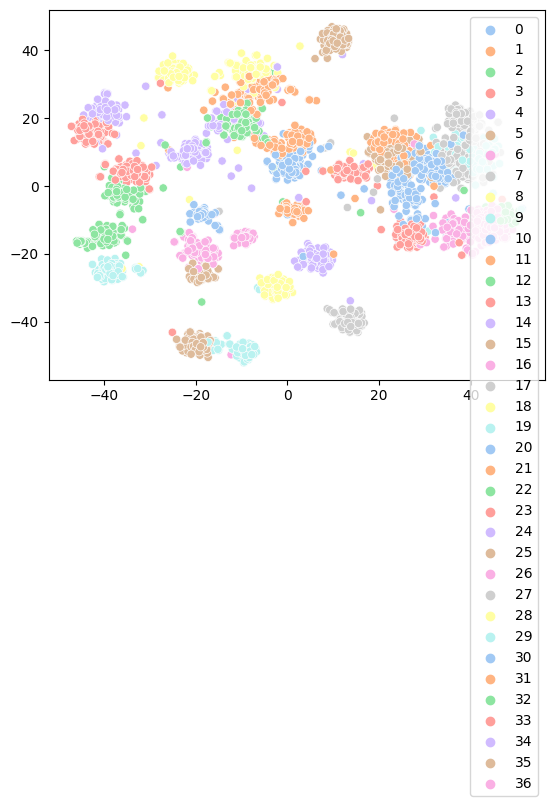

In [21]:
# Doing dimensionality reduction on the embeddings and plotting in clusters
vals = sklearn.manifold.TSNE(2).fit_transform(X_train)

sns.scatterplot(x=vals[:, 0], y=vals[:, 1], hue=y_train, palette='pastel')

In [22]:
# KNN is done through sklearn default method
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

print(knn.predict(X_test))
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

[21 12 10 ...  5  0 36]
0.9224033816425121
0.8400109021531752


k = 1: Train Accuracy: 1.0
k = 1: Test Accuracy: 0.827200872172254
k = 2: Train Accuracy: 0.9242149758454107
k = 2: Test Accuracy: 0.803761242845462
k = 3: Train Accuracy: 0.9338768115942029
k = 3: Test Accuracy: 0.83892068683565
k = 4: Train Accuracy: 0.919987922705314
k = 4: Test Accuracy: 0.8394657944944126
k = 5: Train Accuracy: 0.9224033816425121
k = 5: Test Accuracy: 0.8400109021531752
k = 6: Train Accuracy: 0.9163647342995169
k = 6: Test Accuracy: 0.8397383483237939


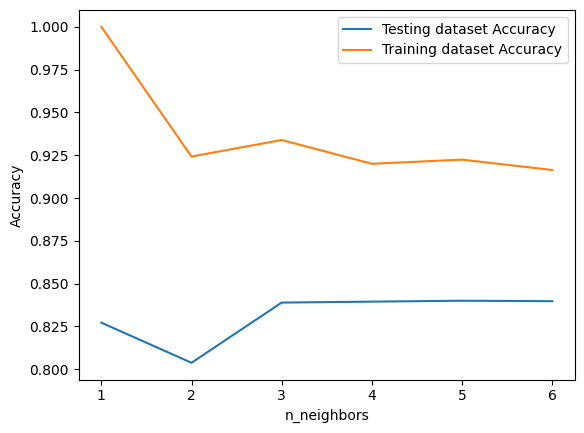

In [23]:
# Observing accuracy of different neighbour values for the KNeighborsClassifier method
neighbors = np.arange(1, 7)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_accuracy[i] = knn.score(X_train, y_train)
    print(f"k = {k}: Train Accuracy: {train_accuracy[i]}")
    test_accuracy[i] = knn.score(X_test, y_test)
    print(f"k = {k}: Test Accuracy: {test_accuracy[i]}")

plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

# 2. Multi Classification

In [39]:
LEARNING_RATE = 0.01  #learning rate for the optimizer
num_classes = 37  #number of classes at the output

In [40]:
from torchvision.models import resnet50, ResNet50_Weights

model2 = copy.deepcopy(resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))
# model2

In [41]:
# Changing only the last fc layer of resnet50 to have 37 classes
model2.fc = nn.Linear(in_features=2048, out_features=num_classes)
# model2

In [42]:
# Number of trainable parameters available in the network
sum(p.numel() for p in model2.parameters() if p.requires_grad)

23583845

Setting only last layer trainable

In [43]:
for param in model2.parameters():
    param.requires_grad = False

for param in model2.fc.parameters():
    param.requires_grad = True

for name, param in model2.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

In [44]:
# Number of trainable parameters available in the modified network
sum(p.numel() for p in model2.parameters() if p.requires_grad)

75813

In [45]:
model2 = model2.to(device)

In [46]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss for multiclass classification
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE) # Adam optimizer is chosen for gradient update

In [47]:
NUM_EPOCHS = 10 # Number of epochs to train/test
train_accuracy1, test_accuracy1, actual_classes1, predicted_classes1 = train(model2, train_loader, train_length, val_loader, val_length, NUM_EPOCHS)

Train iteration: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
Validation iteration: 1 2 3 
Epoch 1/10
Train loss: 27.33873748779297 	 Train accuracy: 0.7270531058311462 Time(s): 28.34097957611084
Validation loss: 1.563321590423584 	 Validation accuracy: 0.83423912525177 Time(s): 82.40525007247925

Epoch 2/10
Train loss: 3.434525966644287 	 Train accuracy: 0.9652777910232544 Time(s): 23.97944450378418
Validation loss: 0.7554644346237183 	 Validation accuracy: 0.9320652484893799 Time(s): 2.8733935356140137

Epoch 3/10
Train loss: 1.5966120958328247 	 Train accuracy: 0.9879226684570312 Time(s): 22.205559492111206
Validation loss: 0.9245989322662354 	 Validation accuracy: 0.91576087474823 Time(s): 3.8231019973754883

Epoch 4/10
Train loss: 0.8940240144729614 	 Train accuracy: 0.9960748553276062 Time(s): 20.957802534103394
Validation loss: 0.8913646936416626 	 Validation accuracy: 0.9130434989929199 Time(s): 2.8324038982391357

Epoch 5/10
Train loss: 0.6261572837829

In [48]:
actual_classes1, predicted_classes1 = test(model2, test_loader)


Test iteration: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Test loss: 10.117618560791016 	 Test accuracy: 0.894794225692749 Time(s): 26.473622798919678


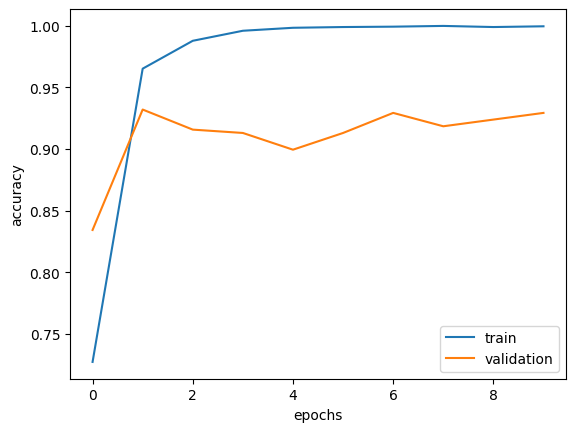

In [49]:
plot_accuracy(train_accuracy1, test_accuracy1)

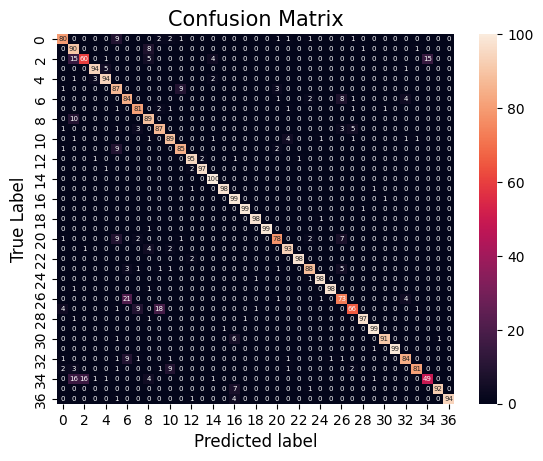

In [50]:
plot_confusion(actual_classes1, predicted_classes1)

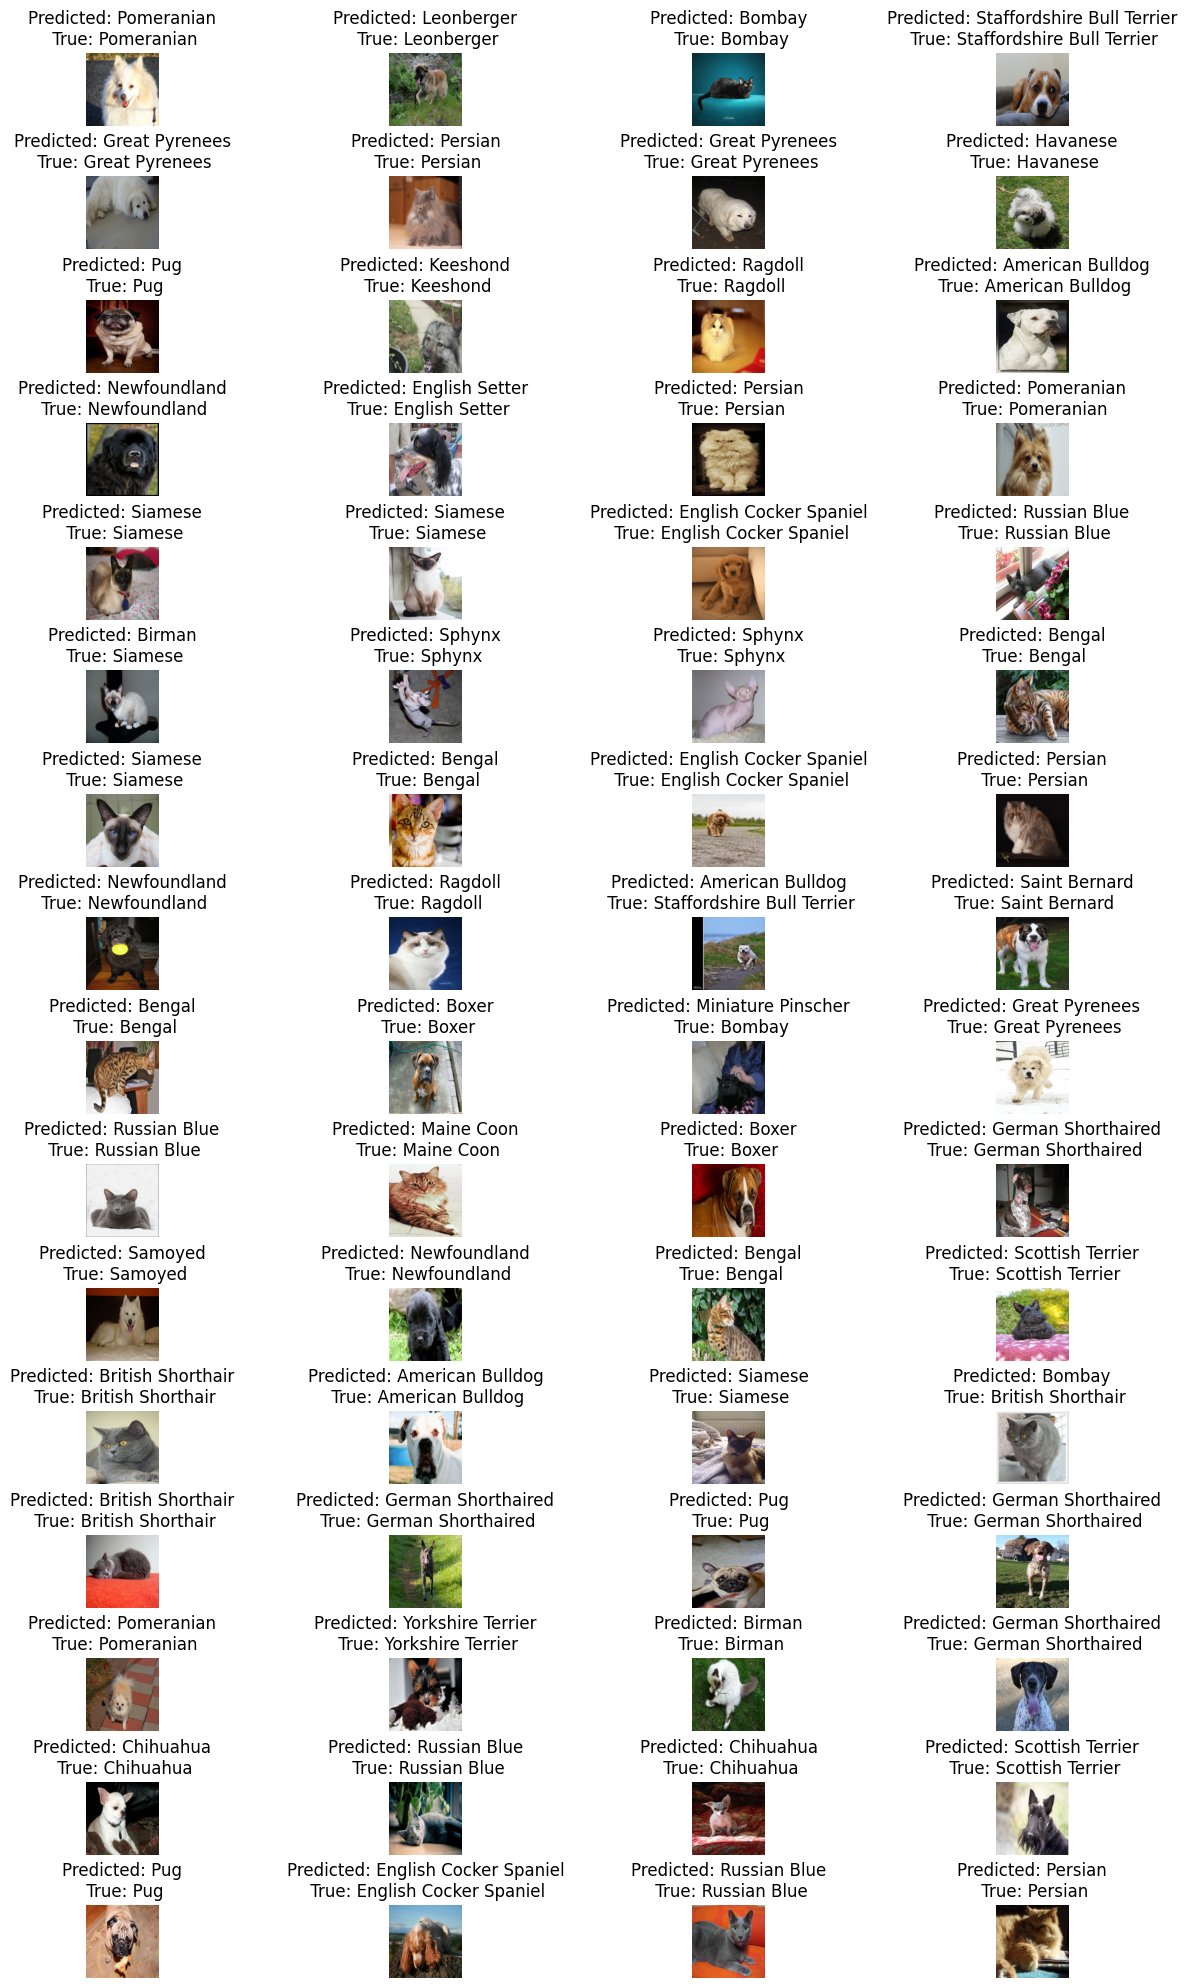

In [51]:
visualize(model2, 64)

# 3. Finetune Alone

In [ ]:
LEARNING_RATE = 0.0001  #learning rate for the optimizer
num_classes = 37  #number of classes at the output

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

model3 = copy.deepcopy(resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))

In [ ]:
# Changing only the last fc layer of resnet50 to have 37 classes
model3.fc = nn.Linear(in_features=2048, out_features=num_classes)
# model3

In [ ]:
# Number of trainable parameters available in the network
sum(p.numel() for p in model3.parameters() if p.requires_grad)

23583845

Setting all the layers trainable

In [ ]:
for param in model3.parameters():
    param.requires_grad = True

for name, param in model3.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True


In [ ]:
# Number of trainable parameters available in the modified network
sum(p.numel() for p in model3.parameters() if p.requires_grad)

23583845

In [ ]:
model3 = model3.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss for multiclass classification
optimizer = optim.Adam(model3.parameters(), lr=LEARNING_RATE) # Adam optimizer is chosen for gradient update
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
NUM_EPOCHS = 10 # Number of epochs to train/test
train_accuracy2, test_accuracy2, actual_classes2, predicted_classes2 = train(model3, train_loader, train_length, val_loader, val_length, NUM_EPOCHS)

Train iteration: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
Validation iteration: 1 2 3 
Epoch 1/10
Train loss: 80.0142593383789 	 Train accuracy: 0.3928140103816986 Time(s): 35.76727271080017
Validation loss: 9.051241874694824 	 Validation accuracy: 0.23641304671764374 Time(s): 3.5256686210632324

Epoch 2/10
Train loss: 30.015100479125977 	 Train accuracy: 0.8725845217704773 Time(s): 33.78306245803833
Validation loss: 3.9129631519317627 	 Validation accuracy: 0.70923912525177 Time(s): 3.013794183731079

Epoch 3/10
Train loss: 6.623437404632568 	 Train accuracy: 0.9622584581375122 Time(s): 34.21690654754639
Validation loss: 1.1957545280456543 	 Validation accuracy: 0.907608687877655 Time(s): 3.249235153198242

Epoch 4/10
Train loss: 1.9532649517059326 	 Train accuracy: 0.9906401038169861 Time(s): 35.22938919067383
Validation loss: 0.8531861901283264 	 Validation accuracy: 0.9320652484893799 Time(s): 4.043063163757324

Epoch 5/10
Train loss: 0.782200813293457 

In [ ]:
actual_classes2, predicted_classes2 = test(model3, test_loader)


Test iteration: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Test loss: 7.792520999908447 	 Test accuracy: 0.9234123229980469 Time(s): 26.944761753082275


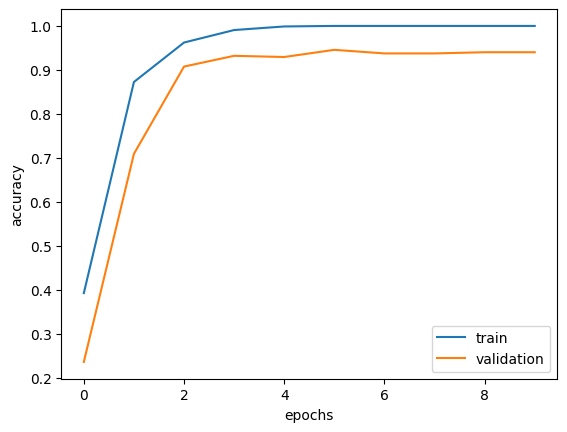

In [ ]:
plot_accuracy(train_accuracy2, test_accuracy2)

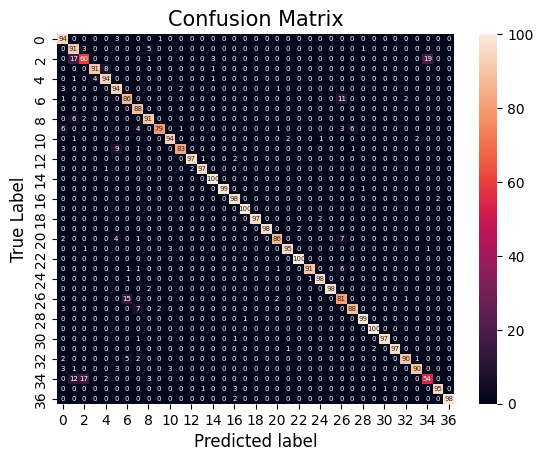

In [ ]:
plot_confusion(actual_classes2, predicted_classes2)

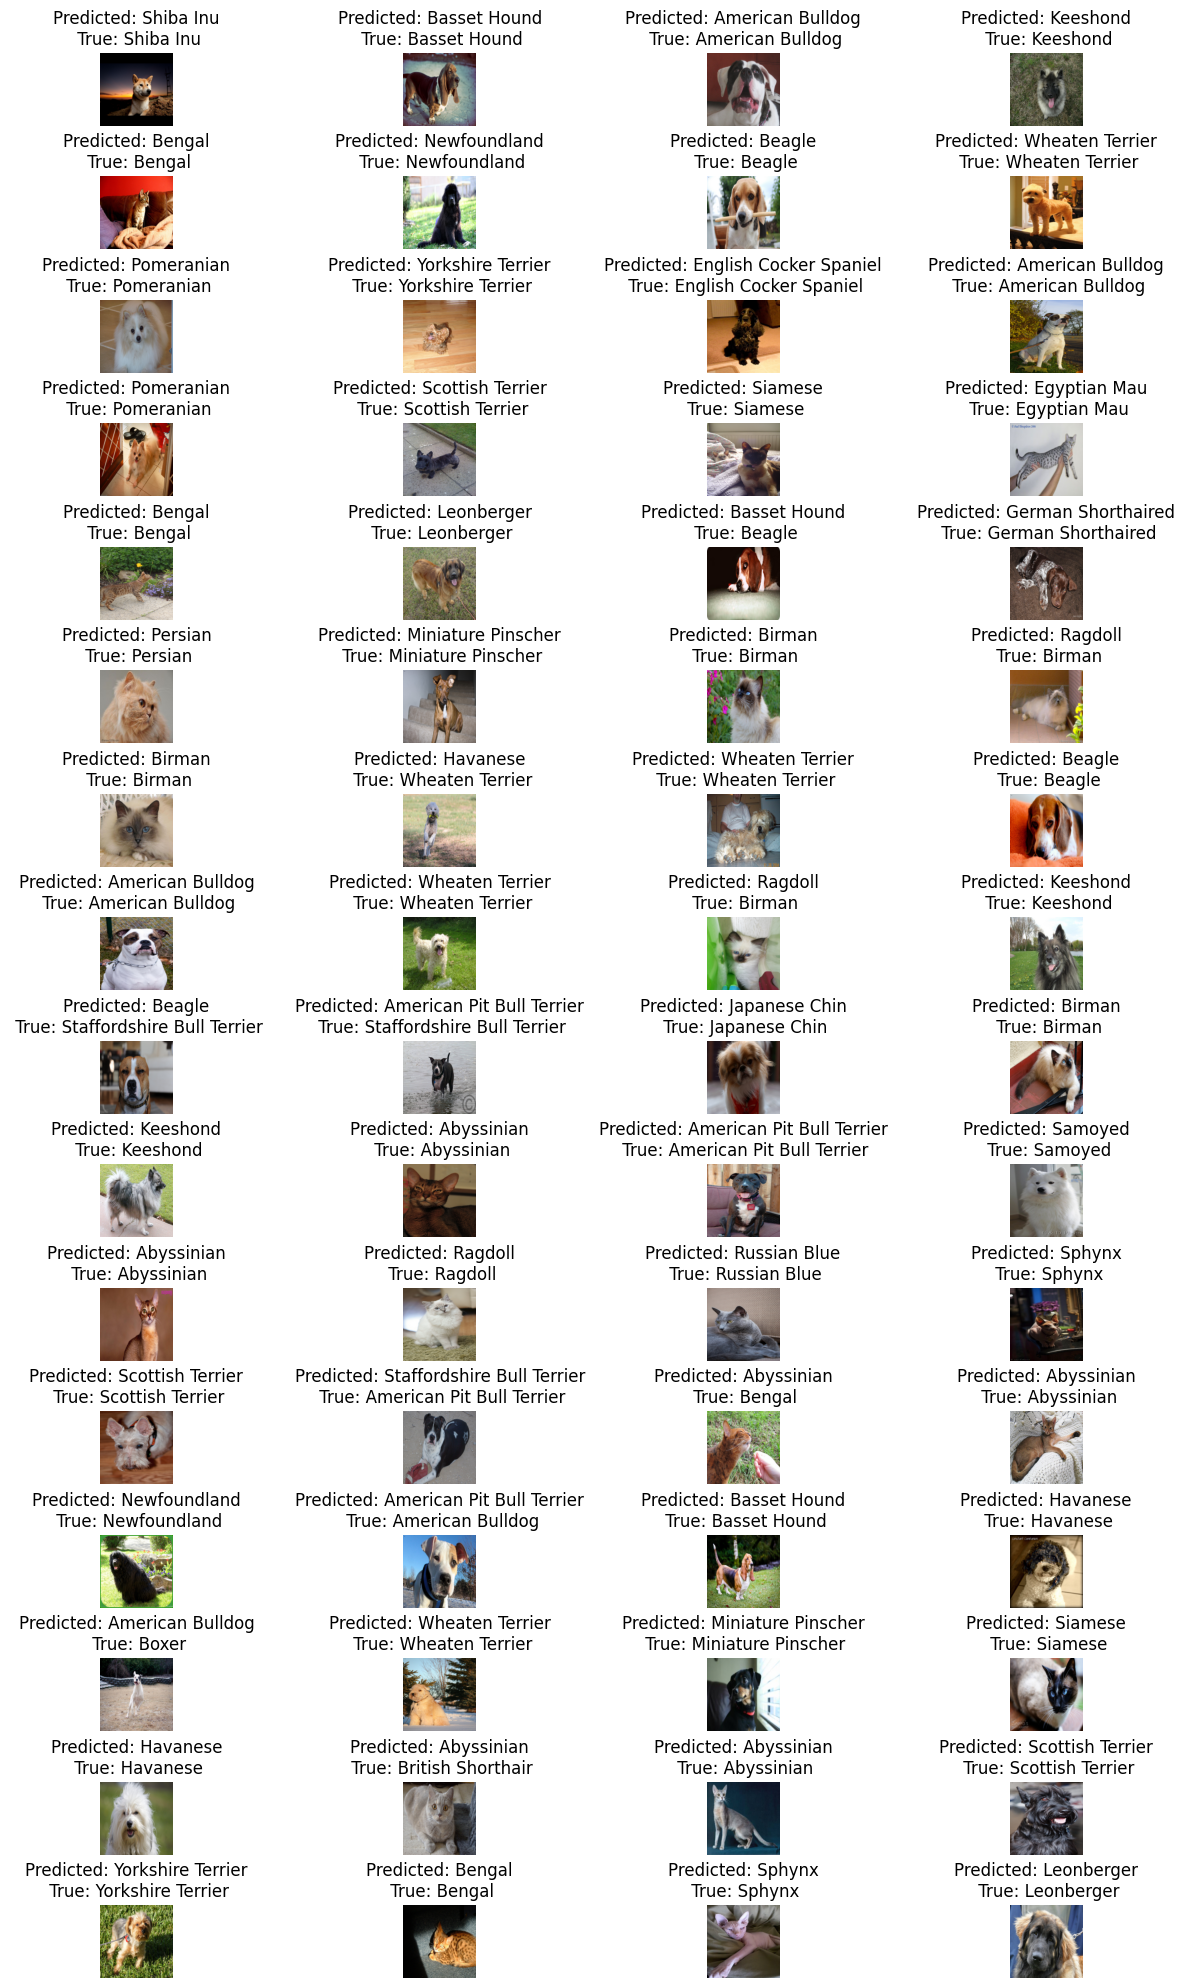

In [ ]:
visualize(model3, 64)

# 3. Finetune with L2 Norm

In [ ]:
LEARNING_RATE = 0.0001  #learning rate for the optimizer
num_classes = 37  #number of classes at the output

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

model3 = copy.deepcopy(resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))

In [ ]:
# Changing only the last fc layer of resnet50 to have 37 classes
model3.fc = nn.Linear(in_features=2048, out_features=num_classes)
# model3

In [ ]:
# Number of trainable parameters available in the network
sum(p.numel() for p in model3.parameters() if p.requires_grad)

23583845

Setting all the layers trainable

In [ ]:
for param in model3.parameters():
    param.requires_grad = True

for name, param in model3.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True


In [ ]:
# Number of trainable parameters available in the modified network
sum(p.numel() for p in model3.parameters() if p.requires_grad)

23583845

In [ ]:
model3 = model3.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss for multiclass classification
optimizer = optim.Adam(model3.parameters(), lr=LEARNING_RATE, weight_decay=0.1) # Adam optimizer is chosen for gradient update
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
NUM_EPOCHS = 10 # Number of epochs to train/test
train_accuracy2, test_accuracy2, actual_classes2, predicted_classes2 = train(model3, train_loader, train_length, val_loader, val_length, NUM_EPOCHS)

Train iteration: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
Validation iteration: 1 2 3 
Epoch 1/10
Train loss: 90.51917266845703 	 Train accuracy: 0.11835748702287674 Time(s): 35.64586782455444
Validation loss: 10.584609031677246 	 Validation accuracy: 0.09510869532823563 Time(s): 3.3865878582000732

Epoch 2/10
Train loss: 77.72891235351562 	 Train accuracy: 0.508152186870575 Time(s): 34.11732363700867
Validation loss: 9.853571891784668 	 Validation accuracy: 0.2038043588399887 Time(s): 2.9726710319519043

Epoch 3/10
Train loss: 50.697628021240234 	 Train accuracy: 0.7971014380455017 Time(s): 34.19280481338501
Validation loss: 7.8769402503967285 	 Validation accuracy: 0.301630437374115 Time(s): 3.351569652557373

Epoch 4/10
Train loss: 22.961698532104492 	 Train accuracy: 0.8864734172821045 Time(s): 35.47950887680054
Validation loss: 5.358182430267334 	 Validation accuracy: 0.6222826242446899 Time(s): 3.5001132488250732

Epoch 5/10
Train loss: 11.95426845550

In [ ]:
actual_classes2, predicted_classes2  = test(model3, test_loader)


Test iteration: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Test loss: 14.679594039916992 	 Test accuracy: 0.8991550803184509 Time(s): 32.7821102142334


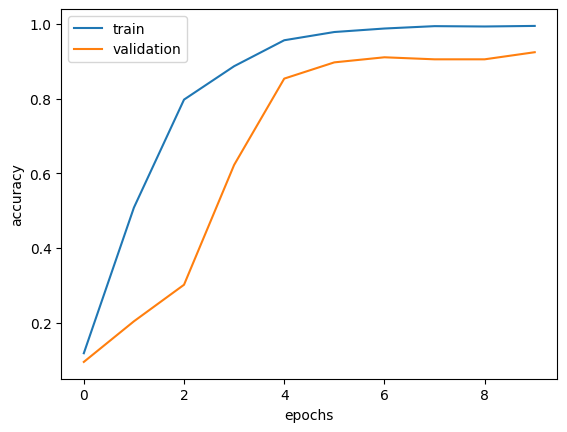

In [ ]:
plot_accuracy(train_accuracy2, test_accuracy2)

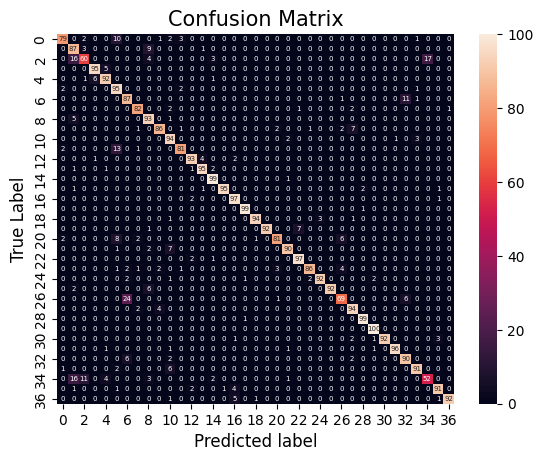

In [ ]:
plot_confusion(actual_classes2, predicted_classes2)

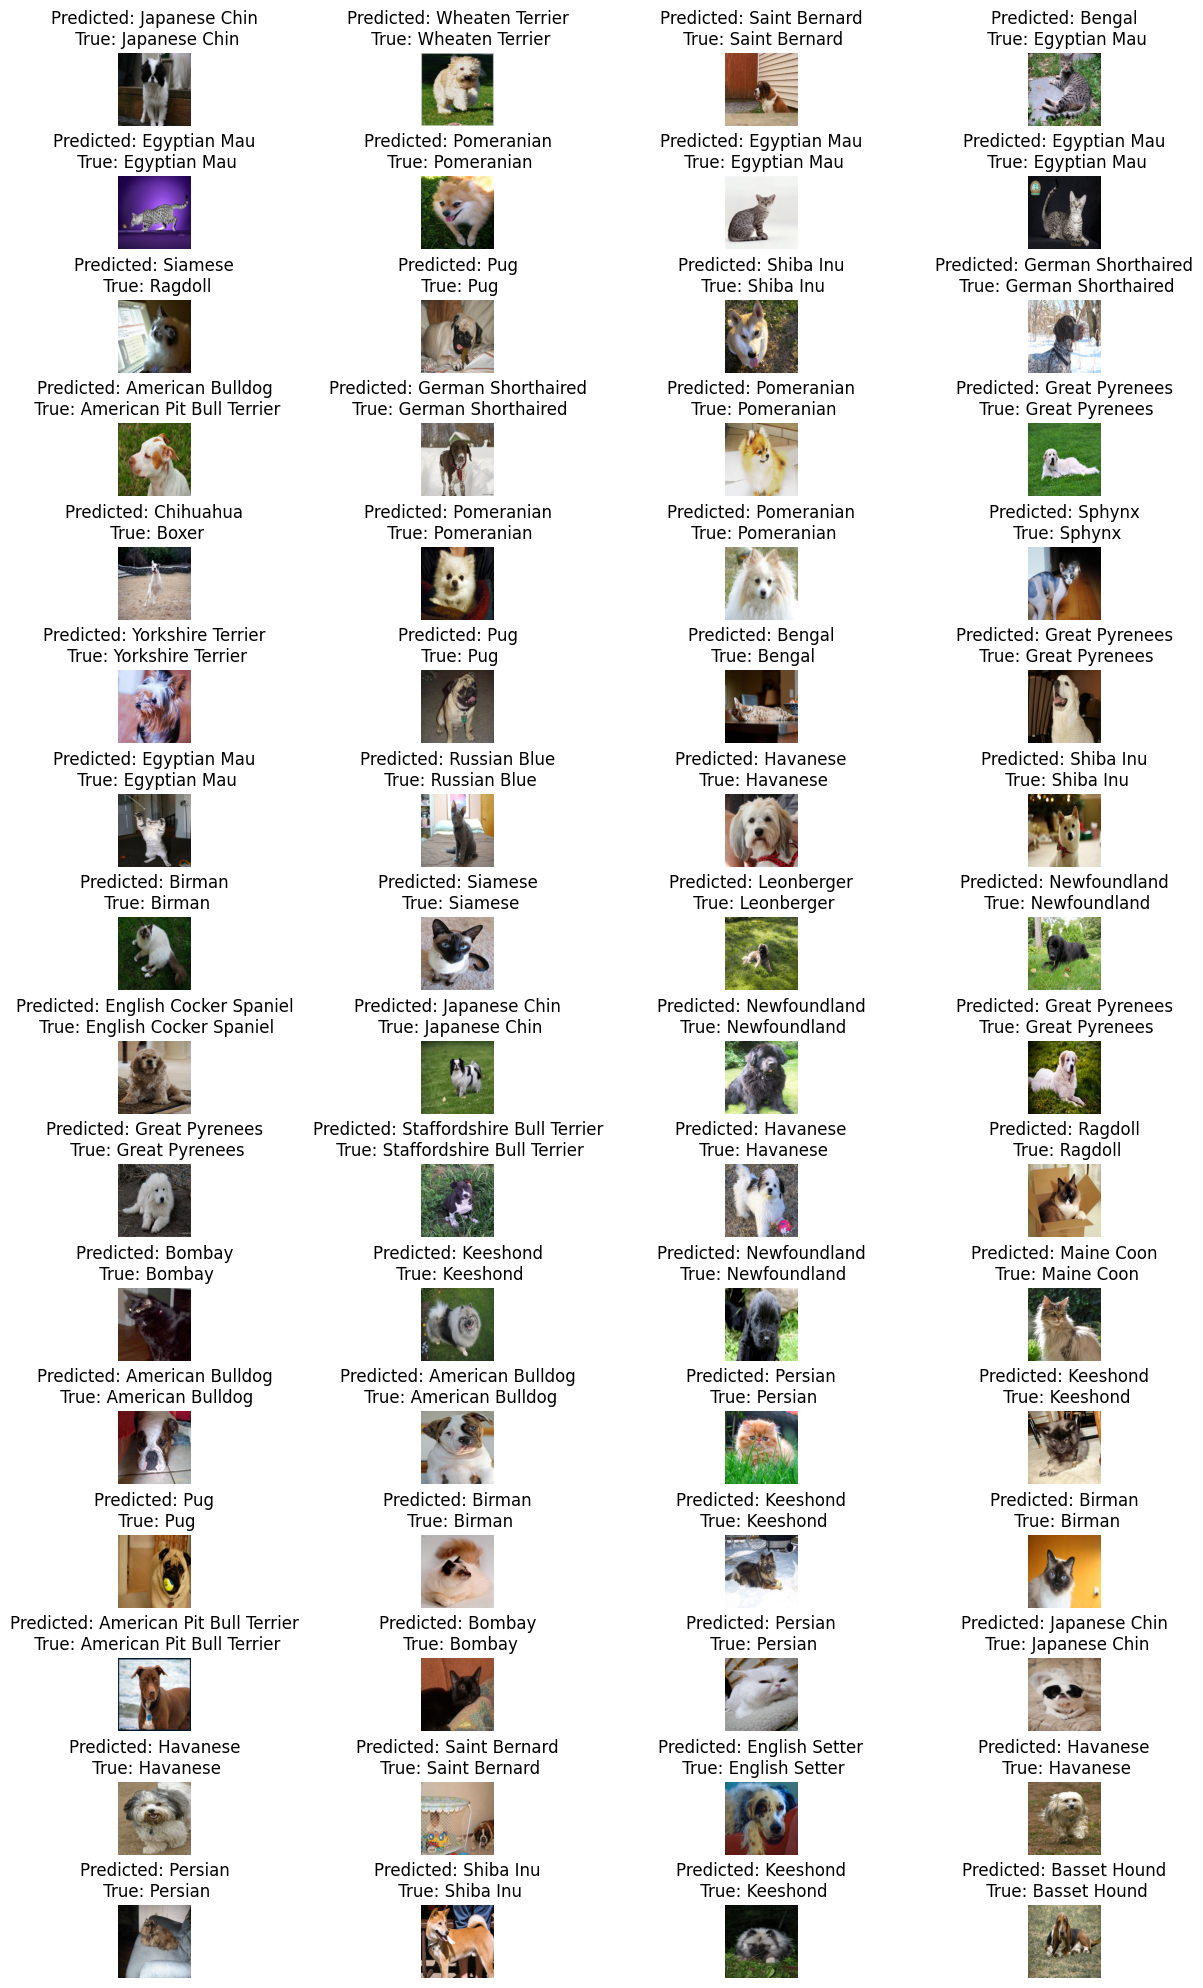

In [ ]:
visualize(model3, 64)

# 3. Finetune with scheduler

In [ ]:
LEARNING_RATE = 0.0001  #learning rate for the optimizer
num_classes = 37  #number of classes at the output

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

model3 = copy.deepcopy(resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))

In [ ]:
# Changing only the last fc layer of resnet50 to have 37 classes
model3.fc = nn.Linear(in_features=2048, out_features=num_classes)
# model3

In [ ]:
# Number of trainable parameters available in the network
sum(p.numel() for p in model3.parameters() if p.requires_grad)

23583845

Setting all the layers trainable

In [ ]:
for param in model3.parameters():
    param.requires_grad = True

for name, param in model3.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True


In [ ]:
# Number of trainable parameters available in the modified network
sum(p.numel() for p in model3.parameters() if p.requires_grad)

23583845

In [ ]:
model3 = model3.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss for multiclass classification
optimizer = optim.Adam(model3.parameters(), lr=LEARNING_RATE, weight_decay=0.1) # Adam optimizer is chosen for gradient update
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
NUM_EPOCHS =NUM_EPOCHS = 10 # Number of epochs to train/test
train_accuracy2, test_accuracy2, actual_classes2, predicted_classes2 = train_with_schedule(model3, train_loader, train_length, val_loader, val_length, NUM_EPOCHS)

Train iteration: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
Validation iteration: 1 2 3 
Epoch 1/10
Train loss: 92.52259826660156 	 Train accuracy: 0.05615941807627678 Time(s): 34.66989040374756
Validation loss: 10.670886039733887 	 Validation accuracy: 0.032608695328235626 Time(s): 3.0000720024108887

Epoch 2/10
Train loss: 91.28573608398438 	 Train accuracy: 0.07850241661071777 Time(s): 34.972235918045044
Validation loss: 10.696558952331543 	 Validation accuracy: 0.02445652149617672 Time(s): 4.751495122909546

Epoch 3/10
Train loss: 91.21418762207031 	 Train accuracy: 0.07820048183202744 Time(s): 34.76893091201782
Validation loss: 10.700114250183105 	 Validation accuracy: 0.02717391401529312 Time(s): 2.9969325065612793

Epoch 4/10
Train loss: 91.20626068115234 	 Train accuracy: 0.08605072647333145 Time(s): 34.37420630455017
Validation loss: 10.705215454101562 	 Validation accuracy: 0.02717391401529312 Time(s): 2.9965035915374756

Epoch 5/10
Train loss: 91.2

Epoch 1/10, Learning Rate: 1.267804982496484e-16
Epoch 2/10, Learning Rate: 1.1410244842468357e-16
Epoch 3/10, Learning Rate: 1.0269220358221522e-16
Epoch 4/10, Learning Rate: 9.24229832239937e-17
Epoch 5/10, Learning Rate: 8.318068490159433e-17
Epoch 6/10, Learning Rate: 7.48626164114349e-17
Epoch 7/10, Learning Rate: 6.737635477029141e-17
Epoch 8/10, Learning Rate: 6.063871929326227e-17
Epoch 9/10, Learning Rate: 5.4574847363936046e-17
Epoch 10/10, Learning Rate: 4.9117362627542443e-17


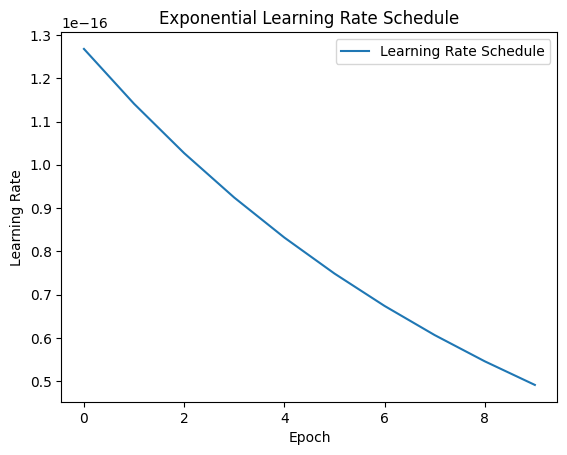

In [ ]:
num_epochs = 10

# Lists to store learning rates and epoch numbers
learning_rates = []
epochs = []

# Perform training loop and record learning rates
for epoch in range(num_epochs):
    # Record the current learning rate and epoch number
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    epochs.append(epoch)

    # Print the current learning rate (optional)
    print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {current_lr}")

    # Update the learning rate using the scheduler
    scheduler.step()

# Plot the learning rate schedule
plt.plot(epochs, learning_rates, label='Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Exponential Learning Rate Schedule')
plt.legend()
plt.show()

In [ ]:
actual_classes2, predicted_classes2 = test(model3, test_loader)


Test iteration: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Test loss: 102.19799041748047 	 Test accuracy: 0.06922867149114609 Time(s): 28.771010160446167


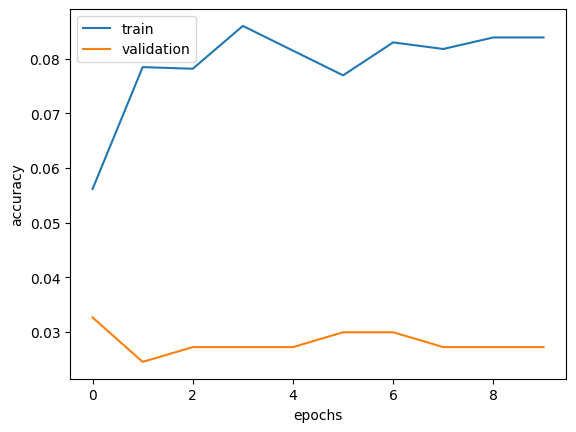

In [ ]:
plot_accuracy(train_accuracy2, test_accuracy2)

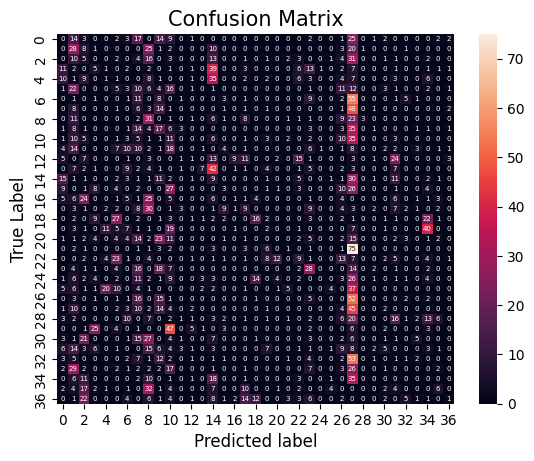

In [ ]:
plot_confusion(actual_classes2, predicted_classes2)

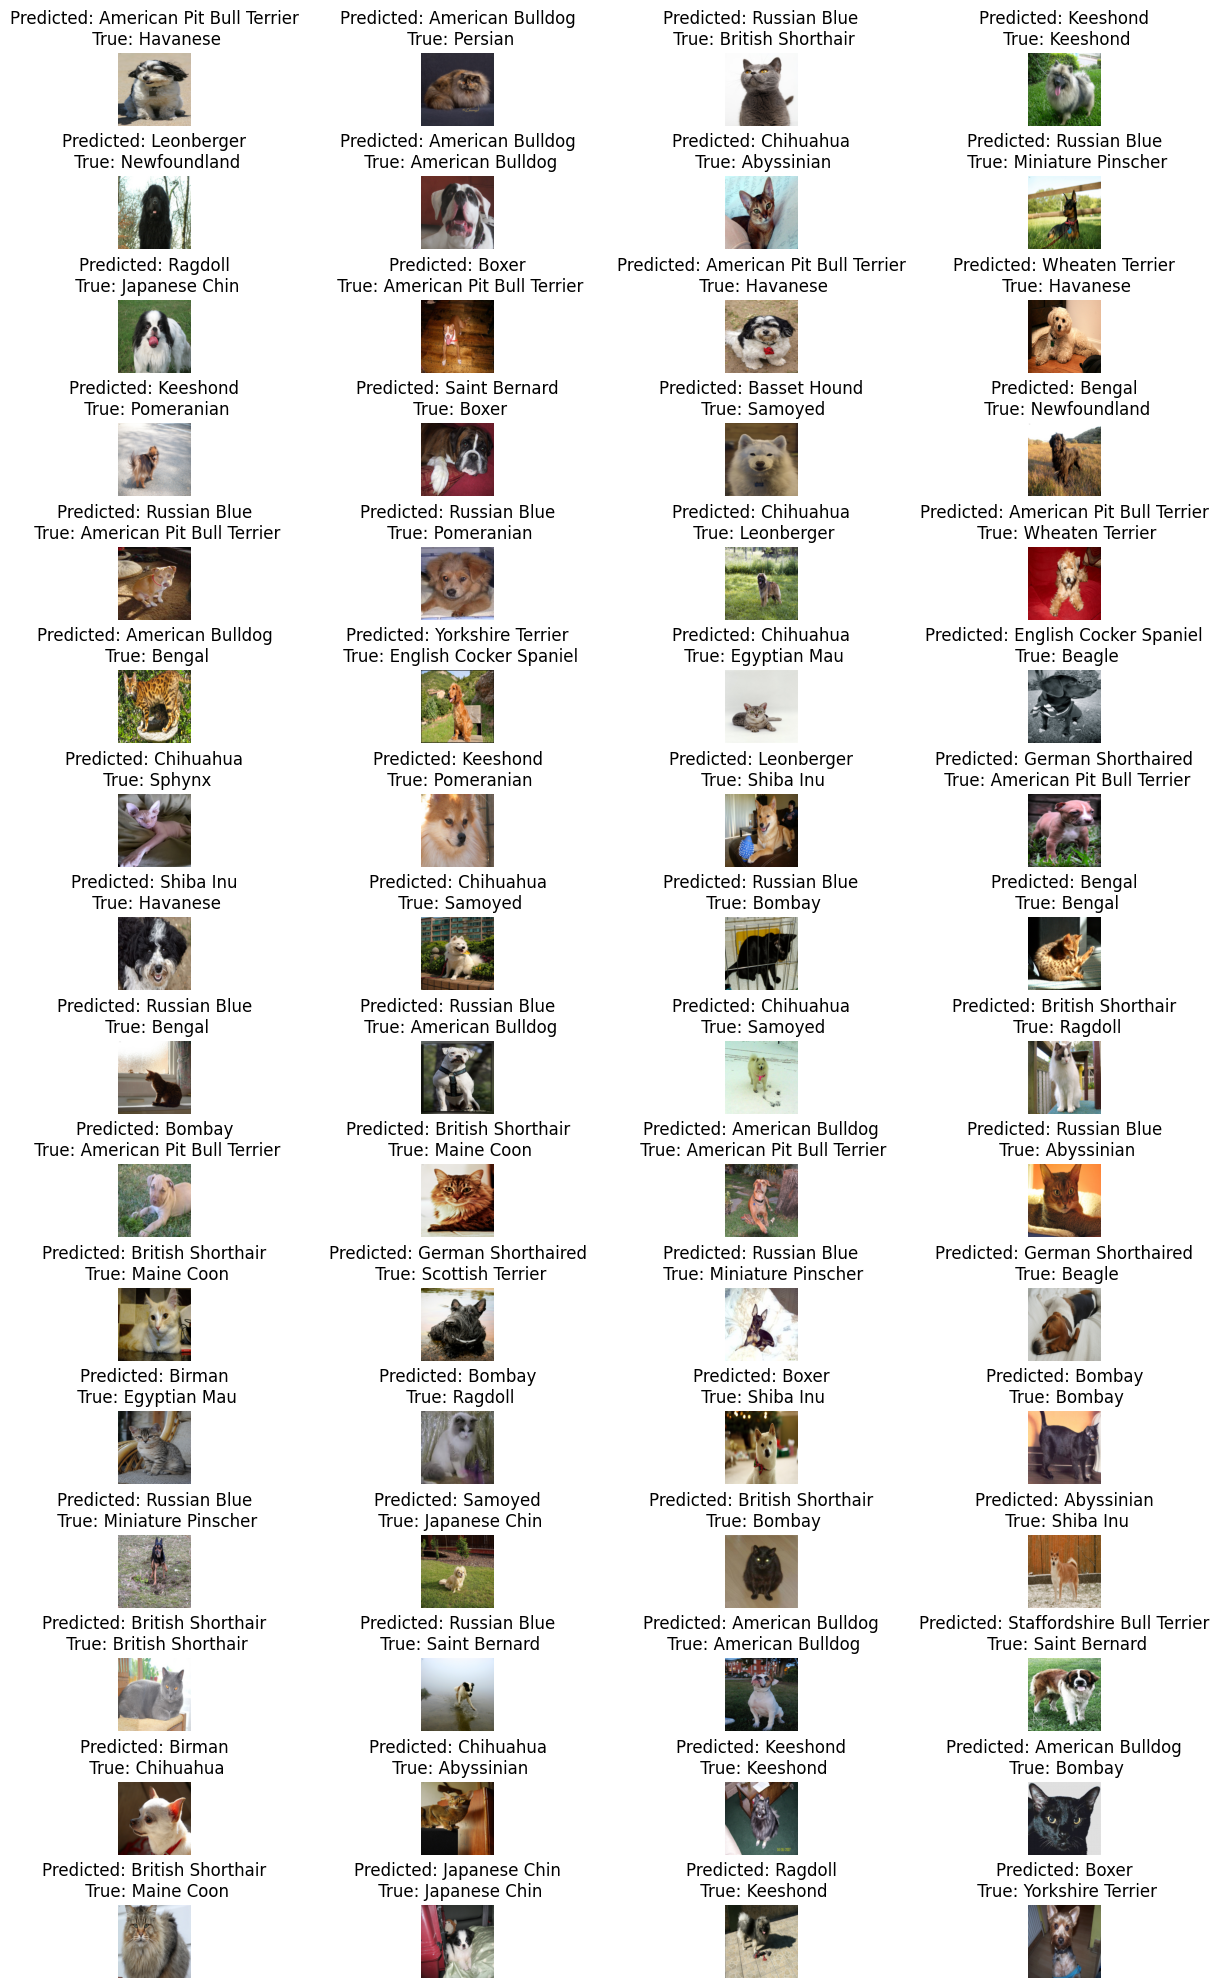

In [ ]:
visualize(model3, 64)